Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [75]:
batch_size = 128
hidden_units = 1024 # hidden nodes
IMAGE_PIXELS = image_size * image_size
graph = tf.Graph()
beta = 5e-4

with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, IMAGE_PIXELS))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables. x - X(hidden)W+B(hidden) -> RELU - X(output)W + B(output) 
  weights_hidden = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden_units], name='weights_hidden'))
  biases_hidden = tf.Variable(tf.zeros([hidden_units]), name='biases_hidden')
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)   
  
  weights_output = tf.Variable(tf.truncated_normal([hidden_units, num_labels]),name='weights_output')
  biases_output = tf.Variable(tf.zeros([num_labels]), name='biases_output') 

  # Training computation.
  logits =  tf.matmul(hidden, weights_output) + biases_output
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  regularization = beta*(tf.nn.l2_loss(weights_hidden) + tf.nn.l2_loss(biases_hidden) + 
                   tf.nn.l2_loss(weights_output) + tf.nn.l2_loss(biases_output))
  loss = loss + regularization  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  valid_hidden_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden) 
  valid_logits = tf.matmul(valid_hidden_prediction, weights_output) + biases_output
  valid_prediction = tf.nn.softmax(valid_logits)
  
  test_hidden_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden) 
  test_logits = tf.matmul(test_hidden_prediction, weights_output) + biases_output  
  test_prediction = tf.nn.softmax(test_logits)

num_steps = 30001

with tf.Session(graph=graph) as session:
  loss_record = []
  mini_acc = []
  valid_acc = [] 
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      loss_record.append(l)
      mini_acc.append(accuracy(predictions, batch_labels))  
      valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))



Initialized
Minibatch loss at step 0: 441.279114
Minibatch accuracy: 8.6%
Validation accuracy: 21.4%
Minibatch loss at step 1000: 99.035637
Minibatch accuracy: 85.2%
Validation accuracy: 80.5%
Minibatch loss at step 2000: 57.273918
Minibatch accuracy: 84.4%
Validation accuracy: 82.6%
Minibatch loss at step 3000: 34.965683
Minibatch accuracy: 85.9%
Validation accuracy: 82.8%
Minibatch loss at step 4000: 21.542337
Minibatch accuracy: 82.0%
Validation accuracy: 85.5%
Minibatch loss at step 5000: 12.967650
Minibatch accuracy: 85.2%
Validation accuracy: 87.2%
Minibatch loss at step 6000: 7.932471
Minibatch accuracy: 89.1%
Validation accuracy: 87.7%
Minibatch loss at step 7000: 4.852909
Minibatch accuracy: 91.4%
Validation accuracy: 88.0%
Minibatch loss at step 8000: 3.232984
Minibatch accuracy: 88.3%
Validation accuracy: 88.7%
Minibatch loss at step 9000: 2.222435
Minibatch accuracy: 89.1%
Validation accuracy: 88.9%
Minibatch loss at step 10000: 1.393599
Minibatch accuracy: 91.4%
Validation

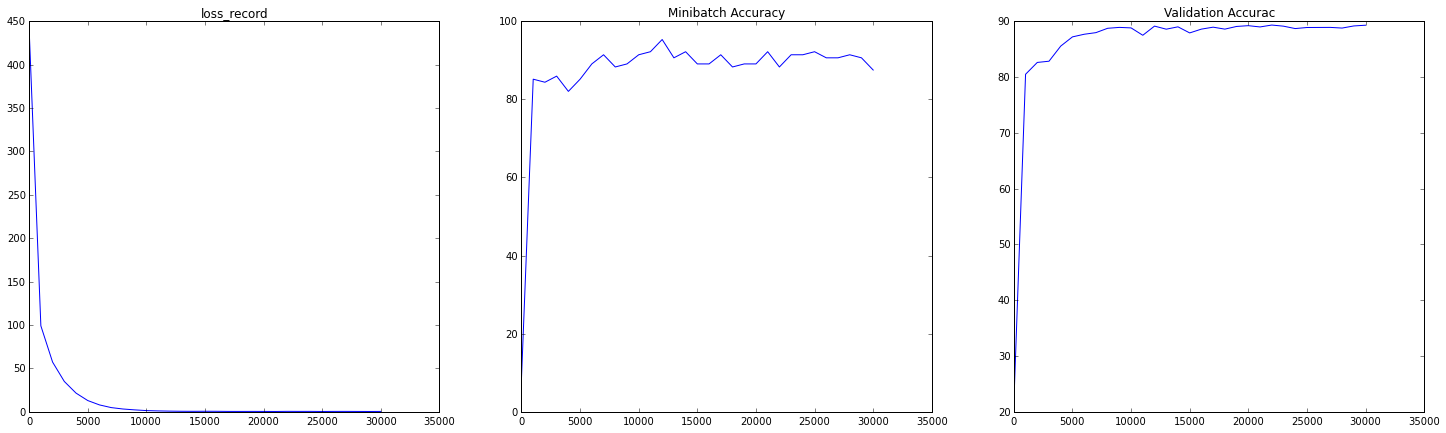

In [76]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
X = np.linspace(0,30001,len(loss_record))
fig, axes = plt.subplots(1, 3, figsize=(25, 7), dpi=200)
axes[0].plot(X,loss_record)
axes[0].set_title("loss_record")
axes[1].plot(X,mini_acc)
axes[1].set_title("Minibatch Accuracy")
axes[2].plot(X,valid_acc)
axes[2].set_title("Validation Accurac")



---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [77]:
batch_size = 56
hidden_units = 1024 # hidden nodes
IMAGE_PIXELS = image_size * image_size
graph = tf.Graph()
beta = 5e-4

with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, IMAGE_PIXELS))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables. x - X(hidden)W+B(hidden) -> RELU - X(output)W + B(output) 
  weights_hidden = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden_units], name='weights_hidden'))
  biases_hidden = tf.Variable(tf.zeros([hidden_units]), name='biases_hidden')
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)   
  
  weights_output = tf.Variable(tf.truncated_normal([hidden_units, num_labels]),name='weights_output')
  biases_output = tf.Variable(tf.zeros([num_labels]), name='biases_output') 

  # Training computation.
  logits =  tf.matmul(hidden, weights_output) + biases_output
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  regularization = beta*(tf.nn.l2_loss(weights_hidden) + tf.nn.l2_loss(biases_hidden) + 
                   tf.nn.l2_loss(weights_output) + tf.nn.l2_loss(biases_output))
  loss = loss + regularization  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  valid_hidden_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden) 
  valid_logits = tf.matmul(valid_hidden_prediction, weights_output) + biases_output
  valid_prediction = tf.nn.softmax(valid_logits)
  
  test_hidden_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden) 
  test_logits = tf.matmul(test_hidden_prediction, weights_output) + biases_output  
  test_prediction = tf.nn.softmax(test_logits)

In [78]:
num_steps = 4001

with tf.Session(graph=graph) as session:
  loss_record = []
  mini_acc = []
  valid_acc = [] 
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      #print("Minibatch loss at step %d: %f" % (step, l))
      #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      loss_record.append(l)
      mini_acc.append(accuracy(predictions, batch_labels))  
      valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Validation accuracy: 29.4%
Validation accuracy: 78.1%
Validation accuracy: 71.9%
Validation accuracy: 77.0%
Validation accuracy: 77.6%
Validation accuracy: 77.0%
Validation accuracy: 74.2%
Validation accuracy: 78.0%
Validation accuracy: 77.9%
Validation accuracy: 75.0%
Validation accuracy: 77.3%
Validation accuracy: 76.2%
Validation accuracy: 78.5%
Validation accuracy: 78.6%
Validation accuracy: 78.0%
Validation accuracy: 78.1%
Validation accuracy: 79.9%
Validation accuracy: 80.0%
Validation accuracy: 79.5%
Validation accuracy: 80.3%
Validation accuracy: 78.1%
Validation accuracy: 78.5%
Validation accuracy: 80.9%
Validation accuracy: 80.9%
Validation accuracy: 80.1%
Validation accuracy: 81.1%
Validation accuracy: 81.3%
Validation accuracy: 81.0%
Validation accuracy: 81.8%
Validation accuracy: 81.8%
Validation accuracy: 82.3%
Validation accuracy: 81.6%
Validation accuracy: 82.0%
Validation accuracy: 80.3%
Validation accuracy: 82.1%
Validation accuracy: 82.5%
Validation accur

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [80]:
batch_size = 128
hidden_units = 1024 # hidden nodes
IMAGE_PIXELS = image_size * image_size
graph = tf.Graph()
beta = 5e-4
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, IMAGE_PIXELS))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables. x - X(hidden)W+B(hidden) -> RELU - X(output)W + B(output) 
  weights_hidden = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden_units], name='weights_hidden'))
  biases_hidden = tf.Variable(tf.zeros([hidden_units]), name='biases_hidden')
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)   
  keep_prob = 0.5
  hidden_layer_drop = tf.nn.dropout(hidden, keep_prob)
  
    
  weights_output = tf.Variable(tf.truncated_normal([hidden_units, num_labels]),name='weights_output')
  biases_output = tf.Variable(tf.zeros([num_labels]), name='biases_output') 

  # Training computation.
  logits =  tf.matmul(hidden_layer_drop, weights_output) + biases_output
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  regularization = beta*(tf.nn.l2_loss(weights_hidden) + tf.nn.l2_loss(biases_hidden) + 
                   tf.nn.l2_loss(weights_output) + tf.nn.l2_loss(biases_output))
  loss = loss + regularization  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  valid_hidden_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden) 
  #valid_drop_prediction =  tf.nn.dropout(valid_hidden_prediction, keep_prob)
  valid_logits = tf.matmul(valid_hidden_prediction, weights_output) + biases_output
  valid_prediction = tf.nn.softmax(valid_logits)
  
  test_hidden_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden) 
  #test_drop_prediction =  tf.nn.dropout(test_hidden_prediction, keep_prob)
  test_logits = tf.matmul(test_hidden_prediction, weights_output) + biases_output  
  test_prediction = tf.nn.softmax(test_logits)

In [81]:
num_steps = 30001

with tf.Session(graph=graph) as session:
  loss_record = []
  mini_acc = []
  valid_acc = [] 
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      loss_record.append(l)
      mini_acc.append(accuracy(predictions, batch_labels))  
      valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 684.121460
Minibatch accuracy: 10.2%
Validation accuracy: 43.1%
Minibatch loss at step 1000: 110.264954
Minibatch accuracy: 74.2%
Validation accuracy: 79.7%
Minibatch loss at step 2000: 60.703880
Minibatch accuracy: 73.4%
Validation accuracy: 79.1%
Minibatch loss at step 3000: 36.035946
Minibatch accuracy: 85.2%
Validation accuracy: 82.7%
Minibatch loss at step 4000: 21.717041
Minibatch accuracy: 76.6%
Validation accuracy: 84.3%
Minibatch loss at step 5000: 13.367912
Minibatch accuracy: 77.3%
Validation accuracy: 85.2%
Minibatch loss at step 6000: 8.227389
Minibatch accuracy: 83.6%
Validation accuracy: 86.5%
Minibatch loss at step 7000: 5.100109
Minibatch accuracy: 86.7%
Validation accuracy: 87.1%
Minibatch loss at step 8000: 3.432080
Minibatch accuracy: 79.7%
Validation accuracy: 87.6%
Minibatch loss at step 9000: 2.363911
Minibatch accuracy: 82.0%
Validation accuracy: 87.9%
Minibatch loss at step 10000: 1.399096
Minibatch accuracy: 89.1%
Validati

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [37]:
import math as math
batch_size = 128
hidden_units = 1024 # hidden nodes
IMAGE_PIXELS = 28*28
graph = tf.Graph()
beta = 5e-4
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, IMAGE_PIXELS))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables. x - X(hidden1)W+B(hidden1) -> RELU - X(hidden2)W+B(hidden2) -> RELU - X(out)W+B(out) 
  weights_hidden1 = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden_units*3], stddev=math.sqrt(2.0/IMAGE_PIXELS)))
  biases_hidden1 = tf.Variable(tf.zeros([hidden_units*3]))
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden1) + biases_hidden1)  

  weights_hidden2 = tf.Variable(tf.truncated_normal([hidden_units*3, hidden_units*2], stddev=math.sqrt(2.0/IMAGE_PIXELS)))
  biases_hidden2 = tf.Variable(tf.zeros([hidden_units*2]))
  hidden2 = tf.nn.relu(tf.matmul(hidden1, weights_hidden2) + biases_hidden2) 
    
  weights_hidden3 = tf.Variable(tf.truncated_normal([hidden_units*2, hidden_units], stddev=math.sqrt(2.0/IMAGE_PIXELS)))
  biases_hidden3 = tf.Variable(tf.zeros([hidden_units]))
  hidden3 = tf.nn.relu(tf.matmul(hidden2, weights_hidden3) + biases_hidden3)  
  
  keep_prob = 0.5
  hidden_layer_drop = tf.nn.dropout(hidden3, keep_prob)

    
  weights_output = tf.Variable(tf.truncated_normal([hidden_units, num_labels], stddev=math.sqrt(2.0/IMAGE_PIXELS)))
  biases_output = tf.Variable(tf.zeros([num_labels])) 

  # Training computation.
  logits =  tf.matmul(hidden_layer_drop, weights_output) + biases_output
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  regularization = beta*(tf.nn.l2_loss(weights_hidden1) + tf.nn.l2_loss(biases_hidden1) + 
                         tf.nn.l2_loss(weights_hidden2) + tf.nn.l2_loss(biases_hidden2) +
                         tf.nn.l2_loss(weights_hidden3) + tf.nn.l2_loss(biases_hidden3) + 
                         tf.nn.l2_loss(weights_output) + tf.nn.l2_loss(biases_output))
  
  loss = loss + regularization  
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.1, global_step, 1000, 0.96, staircase=True)
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  valid_hidden1_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden1) + biases_hidden1) 
  valid_hidden2_prediction = tf.nn.relu(tf.matmul(valid_hidden1_prediction, weights_hidden2) + biases_hidden2) 
  valid_hidden3_prediction = tf.nn.relu(tf.matmul(valid_hidden2_prediction, weights_hidden3) + biases_hidden3)   
  valid_logits = tf.matmul(valid_hidden3_prediction, weights_output) + biases_output
  valid_prediction = tf.nn.softmax(valid_logits)
  
  test_hidden1_prediction = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden1) + biases_hidden1) 
  test_hidden2_prediction = tf.nn.relu(tf.matmul(test_hidden1_prediction, weights_hidden2) + biases_hidden2) 
  test_hidden3_prediction = tf.nn.relu(tf.matmul(test_hidden2_prediction, weights_hidden3) + biases_hidden3)  
  test_logits = tf.matmul(test_hidden3_prediction, weights_output) + biases_output  
  test_prediction = tf.nn.softmax(test_logits)

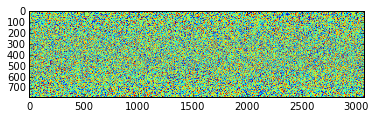

Initialized
Minibatch loss at step 0: 8.725664
Minibatch accuracy: 10.2%
Validation accuracy: 28.7%
Minibatch loss at step 1000: 5.212018
Minibatch accuracy: 88.3%
Validation accuracy: 93.5%
Minibatch loss at step 2000: 4.856246
Minibatch accuracy: 86.7%
Validation accuracy: 94.3%
Minibatch loss at step 3000: 4.325666
Minibatch accuracy: 89.8%
Validation accuracy: 94.8%
Minibatch loss at step 4000: 4.124135
Minibatch accuracy: 85.9%
Validation accuracy: 95.2%
Minibatch loss at step 5000: 3.770573
Minibatch accuracy: 89.1%
Validation accuracy: 95.2%
Minibatch loss at step 6000: 3.414051
Minibatch accuracy: 90.6%
Validation accuracy: 95.3%
Minibatch loss at step 7000: 3.116668
Minibatch accuracy: 96.1%
Validation accuracy: 95.6%
Minibatch loss at step 8000: 3.041161
Minibatch accuracy: 88.3%
Validation accuracy: 95.7%
Minibatch loss at step 9000: 2.829897
Minibatch accuracy: 92.2%
Validation accuracy: 95.8%
Minibatch loss at step 10000: 2.531541
Minibatch accuracy: 93.8%
Validation accur

In [39]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  loss_record = []
  mini_acc = []
  valid_acc = [] 
  tf.initialize_all_variables().run()
  y = session.run(weights_hidden1)
  plt.imshow(y)
  plt.show()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, _,predictions = session.run([optimizer, loss, learning_rate, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      loss_record.append(l)
      mini_acc.append(accuracy(predictions, batch_labels))  
      valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


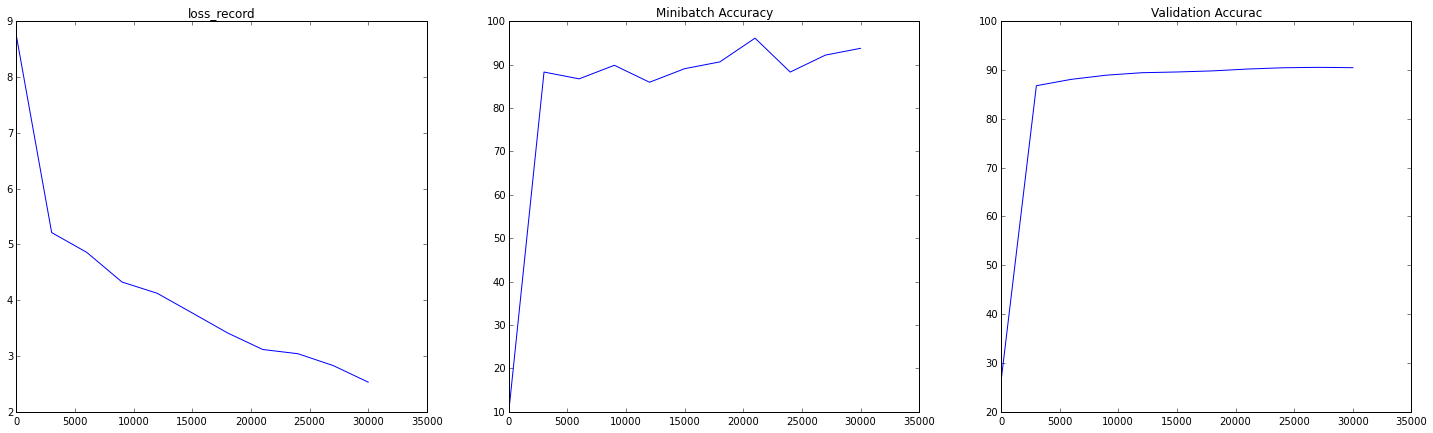

In [40]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
X = np.linspace(0,30001,len(loss_record))
fig, axes = plt.subplots(1, 3, figsize=(25, 7), dpi=200)
axes[0].plot(X,loss_record)
axes[0].set_title("loss_record")
axes[1].plot(X,mini_acc)
axes[1].set_title("Minibatch Accuracy")
axes[2].plot(X,valid_acc)
axes[2].set_title("Validation Accurac")
